In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',110)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings('ignore')
import io
import missingno as msno
%matplotlib inline

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.tools as tls
import plotly.figure_factory as ff
import seaborn as sns
from sklearn.cluster import KMeans, MeanShift
from sklearn import decomposition

from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN

In [2]:
df = pd.read_csv('players_22.csv', index_col = 'sofifa_id')
df

player_url  \
sofifa_id                                                      
158023     https://sofifa.com/player/158023/lionel-messi/...   
188545     https://sofifa.com/player/188545/robert-lewand...   
20801      https://sofifa.com/player/20801/c-ronaldo-dos-...   
190871     https://sofifa.com/player/190871/neymar-da-sil...   
192985     https://sofifa.com/player/192985/kevin-de-bruy...   
...                                                      ...   
261962     https://sofifa.com/player/261962/defu-song/220002   
262040     https://sofifa.com/player/262040/caoimhin-port...   
262760     https://sofifa.com/player/262760/nathan-logue/...   
262820     https://sofifa.com/player/262820/luke-rudden/2...   
264540     https://sofifa.com/player/264540/emanuel-lalch...   

                   short_name                            long_name  \
sofifa_id                                                            
158023               L. Messi       Lionel Andrés Messi Cuccittini   
188545         R. Lewandowski                   Robert Lewandowski   
20801       Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   
190871              Neymar Jr        Neymar da Silva Santos Júnior   
192985           K. De Bruyne                      Kevin De Bruyne   
...                       ...                                  ...   
261962              Song Defu                                  宋德福   
262040              C. Porter                      Caoimhin Porter   
262760               N. Logue              Nathan Logue-Cunningham   
262820              L. Rudden                          Luke Rudden   
264540     E. Lalchhanchhuaha              Emanuel Lalchhanchhuaha   

          player_positions  overall  potential    value_eur  wage_eur  age  \
sofifa_id                                                                    
158023          RW, ST, CF       93         93   78000000.0  320000.0   34   
188545                  ST       92         92  119500000.0  270000.0   32   
20801               ST, LW       91         91   45000000.0  270000.0   36   
190871             LW, CAM       91         91  129000000.0  270000.0   29   
192985             CM, CAM       91         91  125500000.0  350000.0   30   
...                    ...      ...        ...          ...       ...  ...   
261962                 CDM       47         52      70000.0    1000.0   22   
262040                  CM       47         59     110000.0     500.0   19   
262760                  CM       47         55     100000.0     500.0   21   
262820                  ST       47         60     110000.0     500.0   19   
264540                 CAM       47         60     110000.0     500.0   19   

                  dob  height_cm  weight_kg  club_team_id  \
sofifa_id                                                   
158023     1987-06-24        170         72          73.0   
188545     1988-08-21        185         81          21.0   
20801      1985-02-05        187         83          11.0   
190871     1992-02-05        175         68          73.0   
192985     1991-06-28        181         70          10.0   
...               ...        ...        ...           ...   
261962     1999-01-02        180         64      112541.0   
262040     2002-03-18        175         70         445.0   
262760     2000-02-07        178         72      111131.0   
262820     2002-04-23        173         66      111131.0   
264540     2002-02-06        167         61      113040.0   

                     club_name                     league_name  league_level  \
sofifa_id                                                                      
158023     Paris Saint-Germain                  French Ligue 1           1.0   
188545       FC Bayern München            German 1. Bundesliga           1.0   
20801        Manchester United          English Premier League           1.0   
190871     Paris Saint-Germain                  French Ligue 1           1.0   
192985         Ma

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19239 entries, 158023 to 264540
Columns: 109 entries, player_url to nation_flag_url
dtypes: float64(16), int64(43), object(50)
memory usage: 16.1+ MB


In [4]:
df[df.columns[df.isnull().any()]].isnull().sum() * 100 / df.shape[0]

value_eur                     0.384635
wage_eur                      0.317064
club_team_id                  0.317064
club_name                     0.317064
league_name                   0.317064
league_level                  0.317064
club_position                 0.317064
club_jersey_number            0.317064
club_loaned_from             94.272052
club_joined                   6.045013
club_contract_valid_until     0.317064
nation_team_id               96.054889
nation_position              96.054889
nation_jersey_number         96.054889
release_clause_eur            6.112584
player_tags                  92.510006
player_traits                51.151307
pace                         11.081657
shooting                     11.081657
passing                      11.081657
dribbling                    11.081657
defending                    11.081657
physic                       11.081657
goalkeeping_speed            88.918343
club_logo_url                 0.317064
club_flag_url            

### Aqui arriba vemos rapidamente que existen 7 columnas con mas del 80% de los datos como nan, por lo que procederemos a eliminarlas

In [5]:
df = df.drop(columns = ['nation_logo_url','player_tags','player_traits',
                        'nation_jersey_number','nation_position','nation_team_id','club_loaned_from',
                       'goalkeeping_speed'])

### Tambien eliminamos columnas que no aportan valor alguno al estudio actual

In [6]:
df = df.drop(columns = ['player_url','long_name','club_position','nationality_id','player_face_url',
                        'club_logo_url','club_flag_url','nation_flag_url','body_type', 'real_face'])


### Analizamos valores faltantes en el dataset

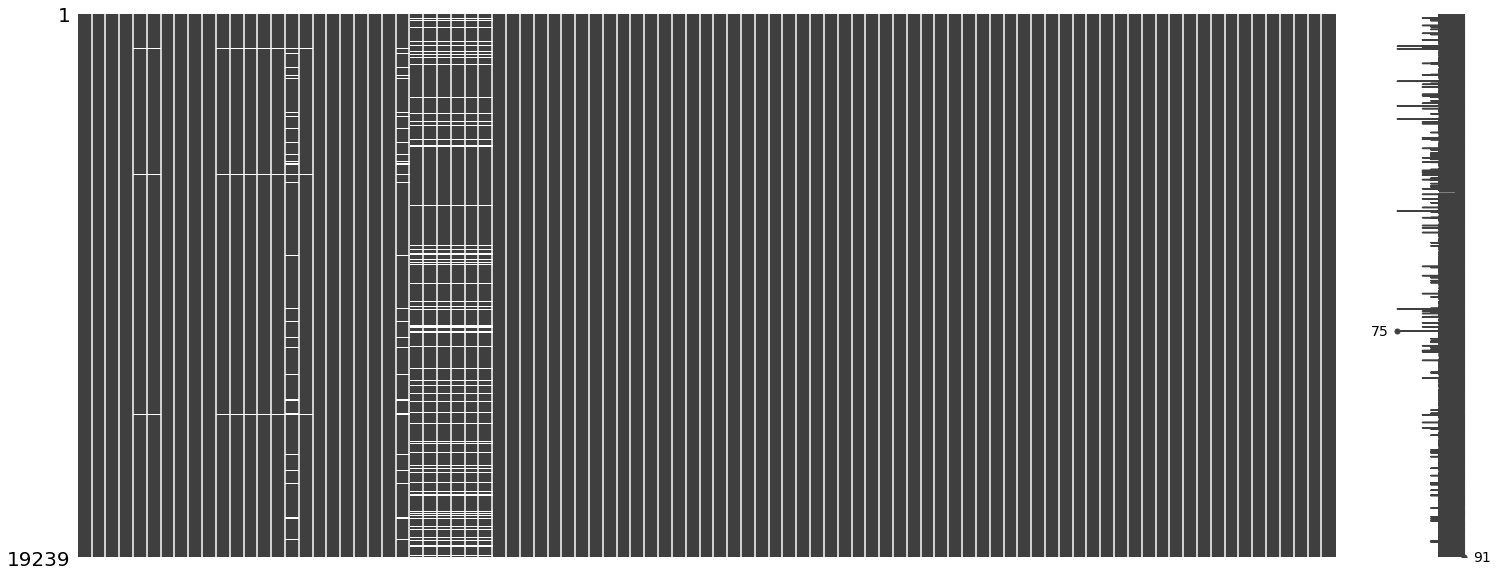

In [7]:
msno.matrix(df);

In [8]:
df.describe().T

count          mean           std      min  \
overall                      19239.0  6.577218e+01  6.880232e+00     47.0   
potential                    19239.0  7.107937e+01  6.086213e+00     49.0   
value_eur                    19165.0  2.850452e+06  7.613700e+06   9000.0   
wage_eur                     19178.0  9.017989e+03  1.947018e+04    500.0   
age                          19239.0  2.521082e+01  4.748235e+00     16.0   
height_cm                    19239.0  1.812997e+02  6.863179e+00    155.0   
weight_kg                    19239.0  7.494303e+01  7.069434e+00     49.0   
club_team_id                 19178.0  5.058050e+04  5.440187e+04      1.0   
league_level                 19178.0  1.354364e+00  7.478651e-01      1.0   
club_jersey_number           19178.0  2.094525e+01  1.790937e+01      1.0   
club_contract_valid_until    19178.0  2.022764e+03  1.213203e+00   2021.0   
weak_foot                    19239.0  2.946151e+00  6.715605e-01      1.0   
skill_moves                  19239.0  2.352461e+00  7.676590e-01      1.0   
international_reputation     19239.0  1.094184e+00  3.710982e-01      1.0   
release_clause_eur           18063.0  5.374044e+06  1.494837e+07  16000.0   
pace                         17107.0  6.821307e+01  1.093315e+01     28.0   
shooting                     17107.0  5.234530e+01  1.405162e+01     18.0   
passing                      17107.0  5.731256e+01  1.006897e+01     25.0   
dribbling                    17107.0  6.256117e+01  9.651312e+00     27.0   
defending                    17107.0  5.170363e+01  1.618975e+01     14.0   
physic                       17107.0  6.482329e+01  9.791886e+00     29.0   
attacking_crossing           19239.0  4.957742e+01  1.803466e+01      6.0   
attacking_finishing          19239.0  4.589443e+01  1.972102e+01      2.0   
attacking_heading_accuracy   19239.0  5.178388e+01  1.729418e+01      5.0   
attacking_short_passing      19239.0  5.886798e+01  1.449086e+01      7.0   
attacking_volleys            19239.0  4.246385e+01  1.765333e+01      3.0   
skill_dribbling              19239.0  5.566043e+01  1.878459e+01      4.0   
skill_curve                  19239.0  4.726893e+01  1.818109e+01      6.0   
skill_fk_accuracy            19239.0  4.224903e+01  1.717859e+01      4.0   
skill_long_passing           19239.0  5.307225e+01  1.502657e+01      9.0   
skill_ball_control           19239.0  5.847201e+01  1.666372e+01      8.0   
movement_acceleration        19239.0  6.465289e+01  1.516740e+01     14.0   
movement_sprint_speed        19239.0  6.471490e+01  1.496543e+01     15.0   
movement_agility             19239.0  6.350008e+01  1.486228e+01     18.0   
movement_reactions           19239.0  6.145002e+01  9.042281e+00     25.0   
movement_balance             19239.0  6.406861e+01  1.432479e+01     15.0   
power_shot_power             19239.0  5.777686e+01  1.319222e+01     20.0   
power_jumping                19239.0  6.481350e+01  1.212298e+01     22.0   
power_stamina                19239.0  6.308488e+01  1.614528e+01     12.0   
power_strength               19239.0  6.500774e+01  1.266352e+01     19.0   
power_long_shots             19239.0  4.664270e+01  1.941158e+01      4.0   
mentality_aggression         19239.0  5.553896e+01  1.697218e+01     10.0   
mentality_interceptions      19239.0  4.661355e+01  2.067708e+01      3.0   
mentality_positioning        19239.0  5.033021e+01  1.962160e+01      2.0   
mentality_vision             19239.0  5.396460e+01  1.365048e+01     10.0   
mentality_penalties          19239.0  4.785872e+01  1.576858e+01      7.0   
mentality_composure          19239.0  5.792983e+01  1.215933e+01     12.0   
defending_marking_awareness  19239.0  4.660175e+01  2.020081e+01      4.0   
defending_standing_tackle    19239.0  4.804558e+01  2.123272e+01      5.0   
defending_sliding_tackle     19239.0  4.590670e+01  2.075568e+01      5.0   
goalkeeping_diving           19239.0  1.640610e+01  1.757403e+01      2.0   
goalkeeping_handling       

### Distribucion de la edad en los jugadores:

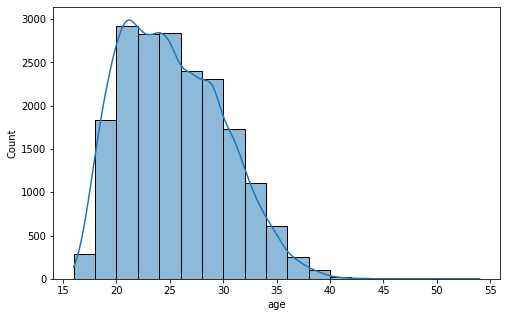

In [9]:
plt.figure(figsize = (8,5))
sns.histplot(data = df, x = 'age',bins = 10, kde = True, binwidth = 2);

### Distribucion del overall (puntaje) de los jugadores:

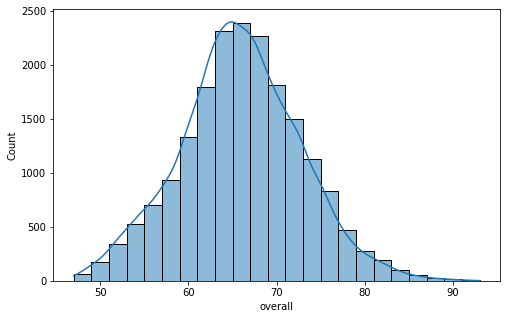

In [10]:
plt.figure(figsize = (8,5))
sns.histplot(data = df, x = 'overall',bins = 10, kde = True, binwidth = 2);

### Nivel de liga se encuentran los jugadores, la mayoria estan en un nivel 1; osea la mas competetiva:

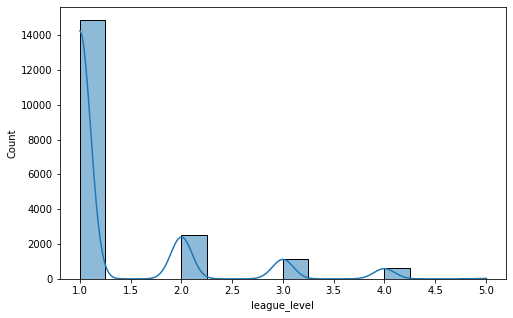

In [11]:
plt.figure(figsize = (8,5))
sns.histplot(data = df, x = 'league_level', kde = True);

### Notamos que ahora los jugadores tienen mas de una posicion, a diferencia del dataset del fifa 19. Para fines utiles y practicos vamos a quedarnos tan solo con la posicion principal de cada jugador. La cual es la primera de cada fila:

In [12]:
df.player_positions.head()

sofifa_id
158023    RW, ST, CF
188545            ST
20801         ST, LW
190871       LW, CAM
192985       CM, CAM
Name: player_positions, dtype: object

In [13]:
df[['Posicion','posicion2','posicion3']] = df.player_positions.str.split(pat = ',', expand = True)
df = df.drop(columns = ['player_positions','posicion2','posicion3'])
df.Posicion.head()

sofifa_id
158023    RW
188545    ST
20801     ST
190871    LW
192985    CM
Name: Posicion, dtype: object

### Mejor jugador por cada posicion:

In [14]:
best_players_per_position = df.loc[df.groupby(df['Posicion'])['overall'].idxmax()][['Posicion',
                                                                                     'short_name','overall']]
best_players_per_position

Posicion           short_name  overall
sofifa_id                                       
212198         CAM      Bruno Fernandes       88
203376          CB          V. van Dijk       89
215914         CDM             N. Kanté       90
165153          CF           K. Benzema       89
192985          CM         K. De Bruyne       91
200389          GK             J. Oblak       91
216267          LB         A. Robertson       87
200104          LM               H. Son       89
190871          LW            Neymar Jr       91
202884         LWB        L. Spinazzola       83
231281          RB  T. Alexander-Arnold       87
233049          RM            J. Sancho       87
158023          RW             L. Messi       93
220093         RWB          H. Hateboer       81
188545          ST       R. Lewandowski       92

### Conteo de jugadores por cada posicion:

In [15]:
pd.DataFrame(df.Posicion.value_counts())

Posicion
CB       3339
ST       2608
CM       2173
GK       2132
CDM      1665
LB       1360
RB       1346
CAM      1151
RM       1028
LM       1016
RW        495
LW        435
RWB       178
LWB       171
CF        142

### Aqui abajo vemos los clubes que tienen el mejor promedio de overall

In [16]:
club_avg_overall = df.groupby('club_name')['overall'].mean().reset_index().sort_values('overall',ascending = False)
club_avg_overall.head()

club_name    overall
368             Juventus  79.961538
470  Paris Saint-Germain  79.454545
358                Inter  78.857143
241    FC Bayern München  78.071429
412    Manchester United  78.000000

### Procedemos a reducir la base de datos. Dejando jugadores tan solo con un overall mayor a 70. Y tan solo algunas columnas seleccionadas
### Tambien creamos variables separando las skills segun el puesto.

In [17]:
n = 10000

df_n = df.iloc[:n]
df_n = df_n[(df_n['overall']>70)]

# Aqui abajo creamos una variable llamada Posicion2, donde resuma las posiciones de los jugadores
# en tan solo 4 posiciones
Delantero = ['RF','ST','LW','LF','RS','LS','RM','LM','RW']
Mediocampista = ['RCM','LCM','LDM','CAM','CDM','LAM','RDM','CM','RAM','CF']
Defensor = ['RCB','CB','LCB','LB','RB','RWB','LWB']
Arquero = ['GK']

def pos2(posicion):
    if posicion in Delantero:
        return 'Delantero'
    elif posicion in Mediocampista:
        return 'Mediocampista'
    elif posicion in Defensor:
        return 'Defensor'
    elif posicion in Arquero:
        return 'Arquero'
    
    else:
        return 'nan'
    
df_n['Posicion2'] = df_n['Posicion'].apply(lambda x: pos2(x))

# Creamos un objeto con todas las skills
skills_ra = [ 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

# Skills de arquero:
skills_gk = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes','Posicion2']

# Skills de defensor:
skills_def = [ 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle','Posicion2']
# Skills de atacantes:
skills_at = ['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing', 'Posicion2']

# Skills de mediocampo:
skills_mid = ['skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'Posicion2']

# Skills de Movimiento y balance
skills_movement = ['movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'Posicion2']

# Skills de Fuerza
skills_power = ['power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'Posicion2']

# Skills Mentales
skills_mental = ['mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'Posicion2']


print(len(skills_ra), 'Variables numericas de desempeño segun habilidades')

40 Variables numericas de desempeño segun habilidades


### Aqui comparamos dos habilidades (disparo al arco y pase), y a su vez creamos dos colores para diferenciar los jugadores que son derechos (naranjas) y los jugadores que son zurdos (azules)

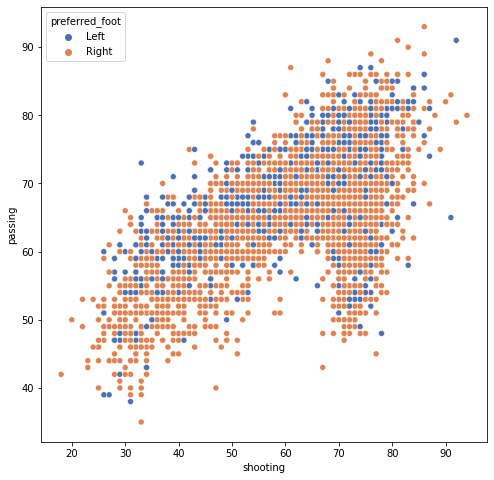

In [18]:
plt.figure(figsize = (8,8))
sns.scatterplot(data = df_n, x = 'shooting', y = 'passing', hue = 'preferred_foot', palette = 'deep');

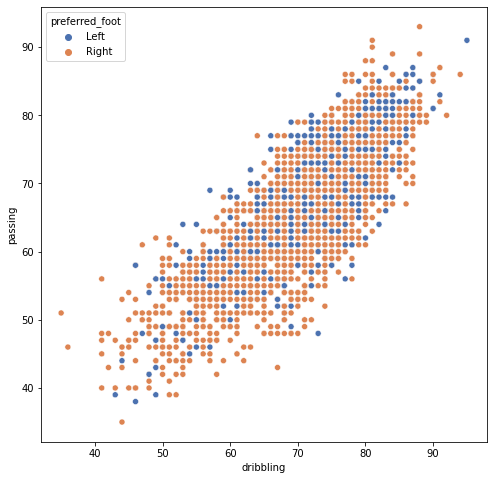

In [19]:
plt.figure(figsize = (8,8))
sns.scatterplot(data = df_n, x = 'dribbling', y = 'passing', hue = 'preferred_foot', palette = 'deep');

### Procedemos a crear al jugador perfecto, y al jugador promedio:

In [20]:
MachineGunDict = {'short_name':'MachineGun','overall':99}
for skills in skills_ra:
    MachineGunDict [skills] = 99
    
df_n = df_n.append(MachineGunDict, ignore_index = True)

JugadorPromedioDict = {'short_name':'Promedio','overall':df_n.overall.mean()}
for skills in skills_ra:
    JugadorPromedioDict [skills] = df_n[skills].mean()
    
df_n = df_n.append(JugadorPromedioDict, ignore_index = True)

In [21]:
df_skills = df_n[skills_ra+ ['Posicion2']]

### Aqui visualizamos las skills propias de arqueros comparandolas para todos

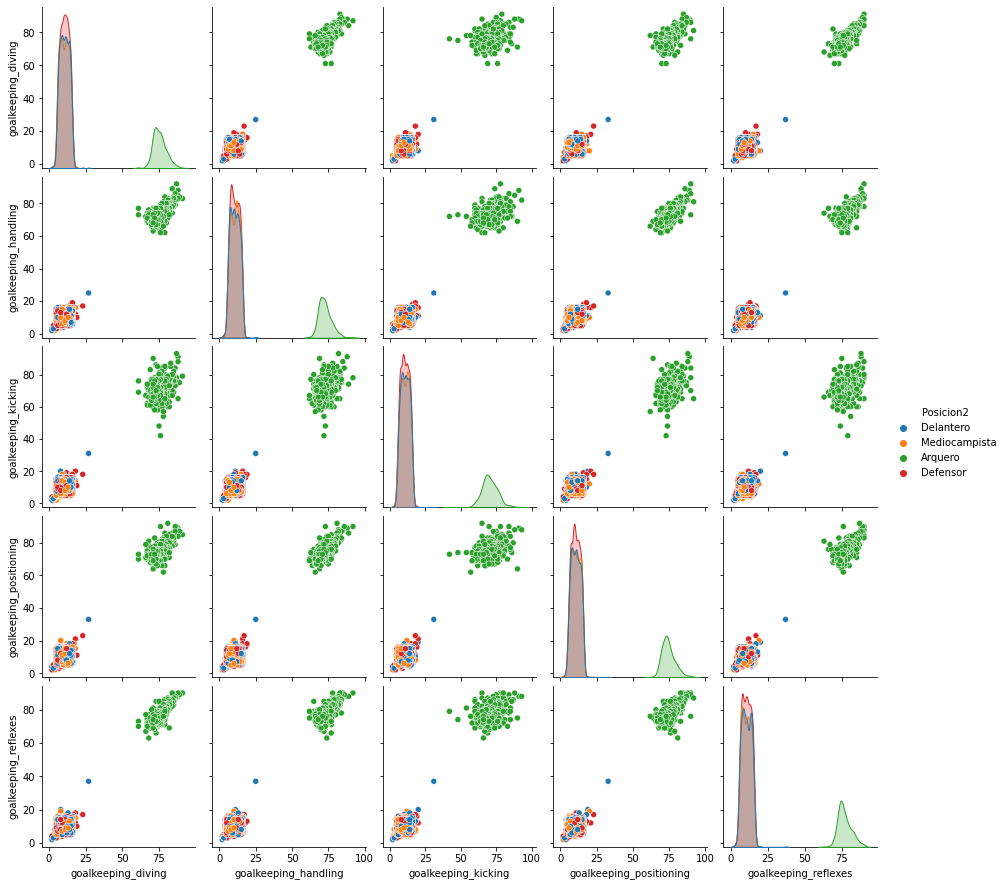

In [22]:
sns.pairplot(df_skills[skills_gk], hue = 'Posicion2');

### Aqui visualizamos las skills propias de defensores comparandolas para todos

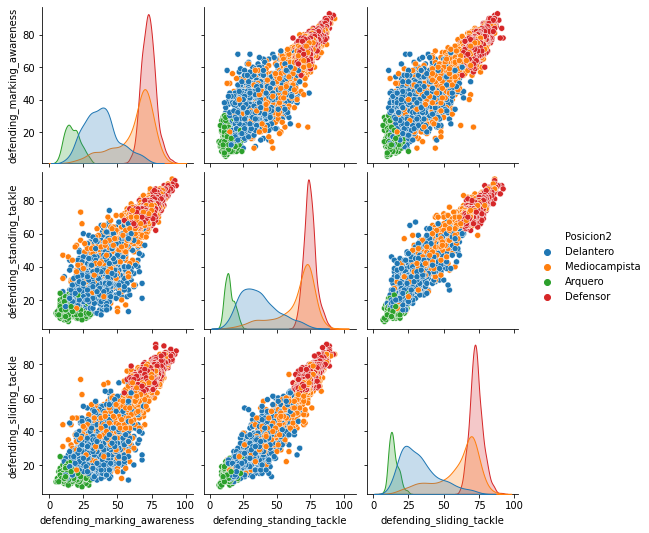

In [23]:
sns.pairplot(df_skills[skills_def], hue ='Posicion2');

### Aqui visualizamos las skills propias de mediocampistas comparandolas para todos

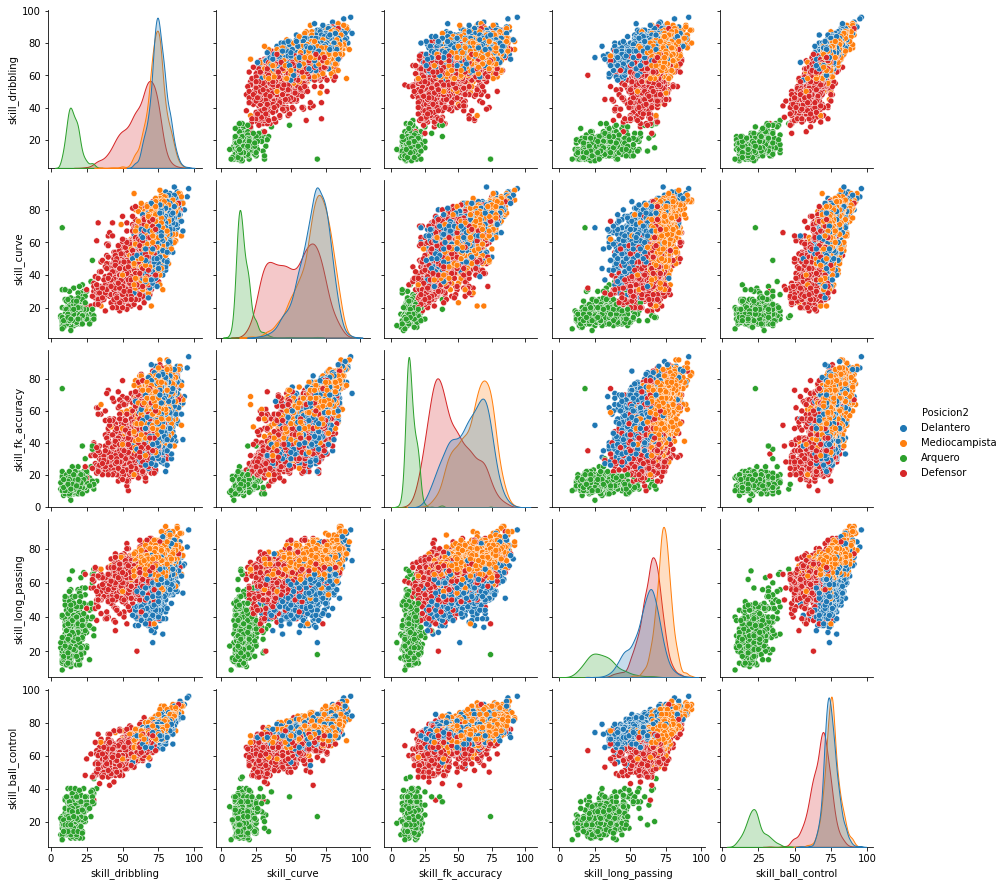

In [24]:
sns.pairplot(df_skills[skills_mid], hue = 'Posicion2');

### Aqui visualizamos las skills propias de delanteros comparandolas para todos

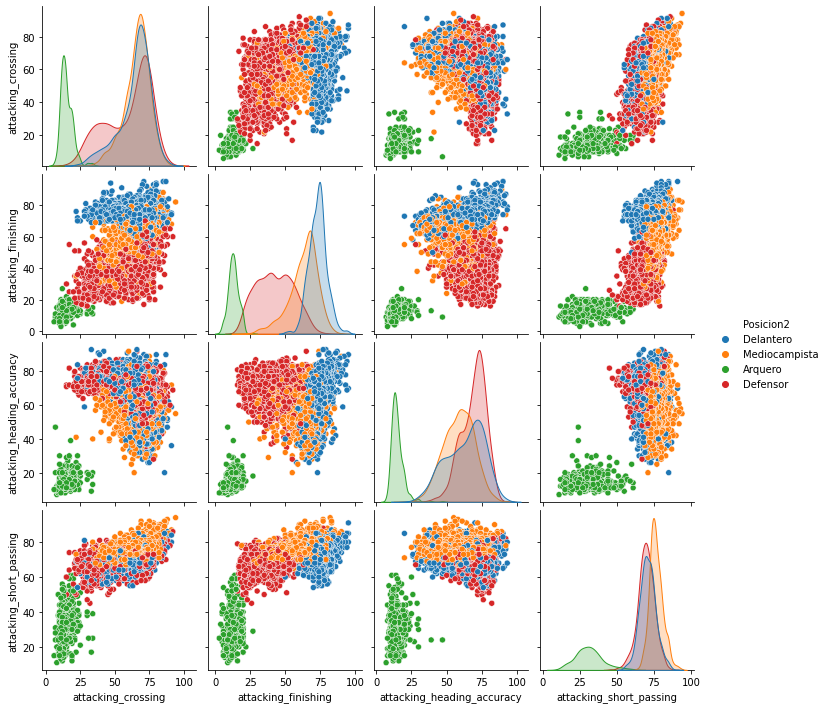

In [25]:
sns.pairplot(df_skills[skills_at], hue = 'Posicion2');

### Aqui visualizamos las skills propias de agilidad y movimientos

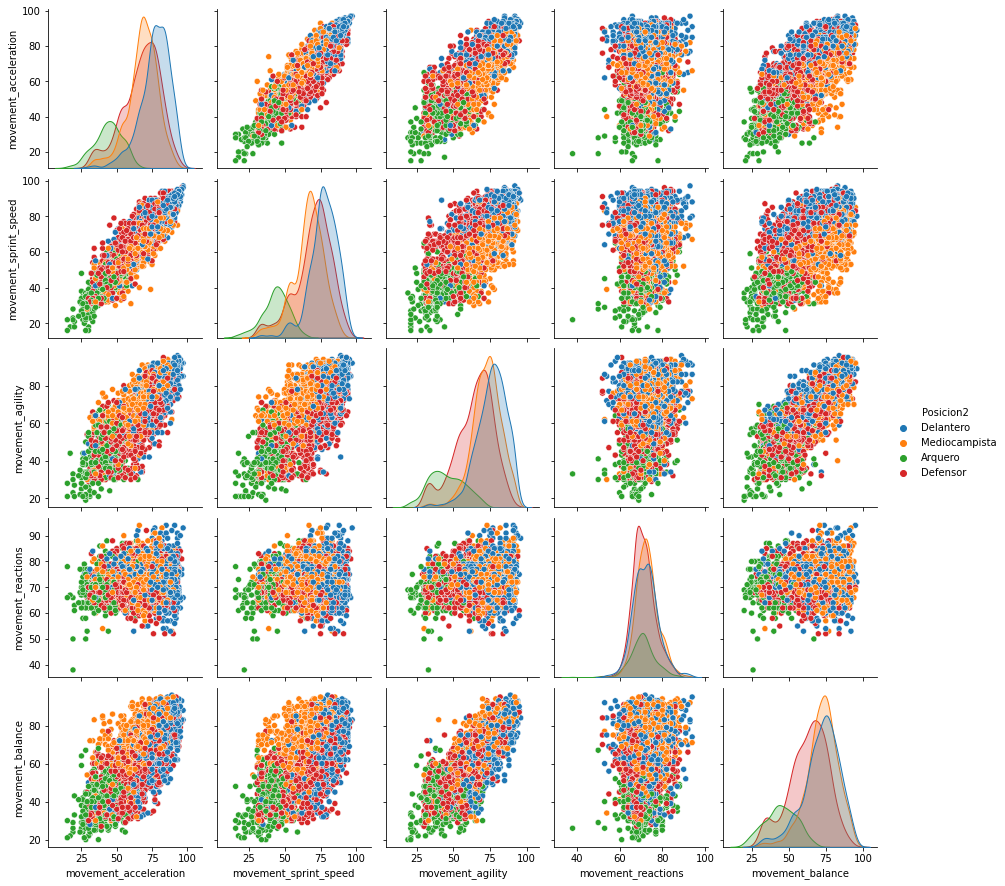

In [26]:
sns.pairplot(df_skills[skills_movement], hue = 'Posicion2');

### Aqui visualizamos las skills de mentalidad

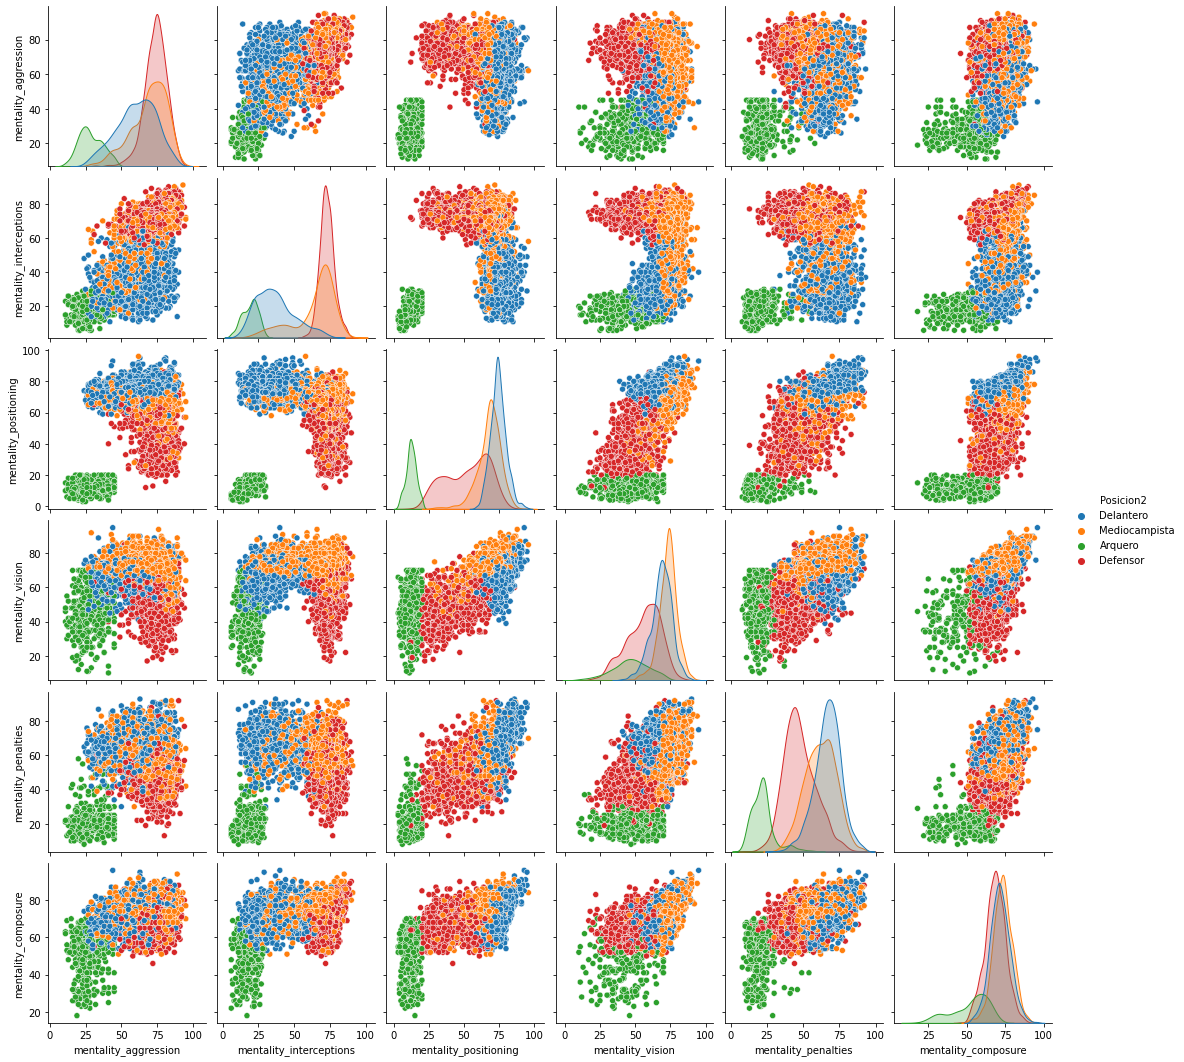

In [27]:
sns.pairplot(df_skills[skills_mental], hue = 'Posicion2');

### Aqui visualizamos las skills de potencia y fuerza

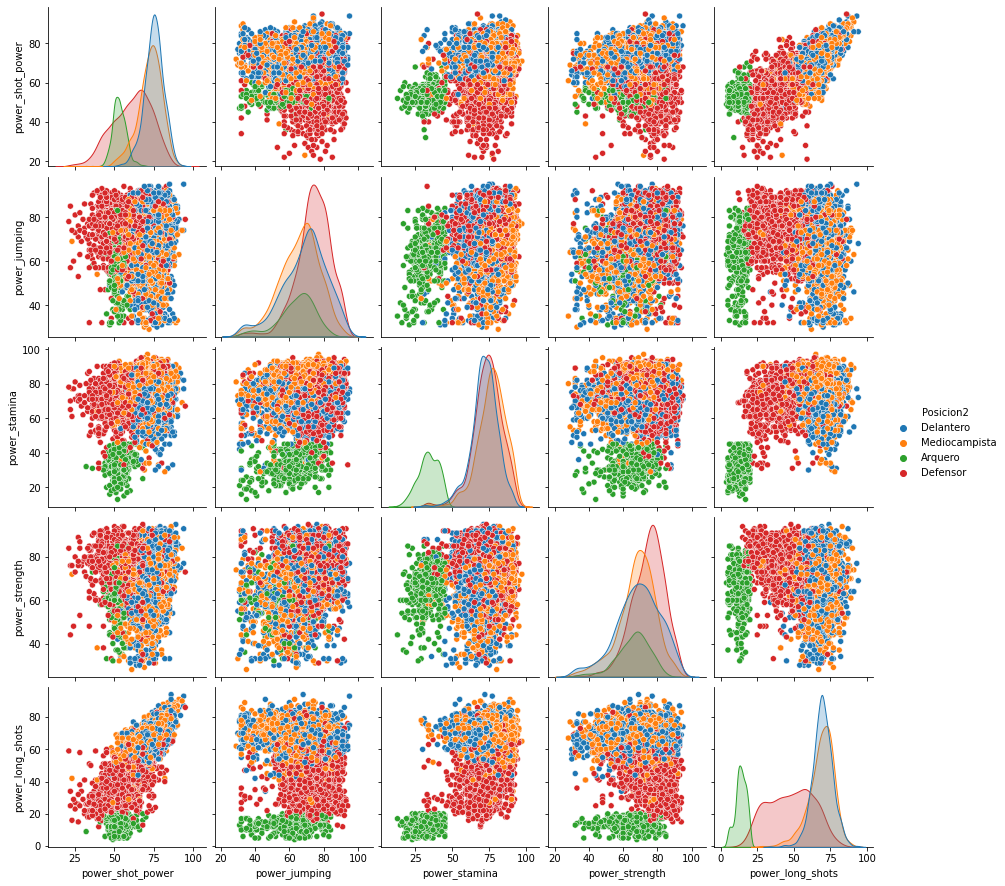

In [28]:
sns.pairplot(df_skills[skills_power], hue = 'Posicion2');

# Clustering con KMeans

In [30]:
df2 = df_skills.copy()
df2 = df2.drop(columns = 'Posicion2')
imputer = SimpleImputer (missing_values = np.nan, strategy = 'most_frequent')
df2 = pd.DataFrame ( imputer.fit_transform(df2), columns = df2.columns, index = df2.index)

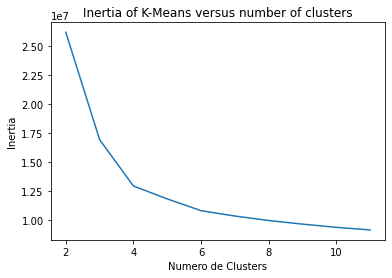

In [32]:
scores = [KMeans (n_clusters = i).fit(df2).inertia_ for i in range (2,12)]

plt.plot(np.arange(2,12), scores);
plt.xlabel('Numero de Clusters')
plt.ylabel('Inertia')
plt.title('Inertia of K-Means versus number of clusters');

In [33]:
n_clust = 4

km = KMeans(n_clusters = n_clust)
km.fit(df2)

clusters = km.labels_

In [34]:
df_clust = df2.copy()
df_clust['kmeans4'] = km.labels_

print('KMeans encontro: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
df_clust

KMeans encontro:  4 clusters, nosotros forzamos la cantidad


pace   shooting    passing  dribbling  defending     physic  \
0     85.000000  92.000000  91.000000  95.000000  34.000000  65.000000   
1     78.000000  92.000000  79.000000  86.000000  44.000000  82.000000   
2     87.000000  94.000000  80.000000  88.000000  34.000000  75.000000   
3     91.000000  83.000000  86.000000  94.000000  37.000000  63.000000   
4     76.000000  86.000000  93.000000  88.000000  64.000000  78.000000   
...         ...        ...        ...        ...        ...        ...   
4590  81.000000  51.000000  66.000000  70.000000  66.000000  67.000000   
4591  76.000000  70.000000  60.000000  65.000000  39.000000  71.000000   
4592  61.000000  62.000000  67.000000  71.000000  65.000000  73.000000   
4593  99.000000  99.000000  99.000000  99.000000  99.000000  99.000000   
4594  70.761446  61.517108  66.737349  70.981928  58.861928  70.770843   

      attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0              85.000000            95.000000                   70.000000   
1              71.000000            95.000000                   90.000000   
2              87.000000            95.000000                   90.000000   
3              85.000000            83.000000                   63.000000   
4              94.000000            82.000000                   55.000000   
...                  ...                  ...                         ...   
4590           70.000000            61.000000                   49.000000   
4591           64.000000            74.000000                   72.000000   
4592           57.000000            61.000000                   54.000000   
4593           99.000000            99.000000                   99.000000   
4594           58.547889            54.389421                   58.903788   

      attacking_short_passing  attacking_volleys  skill_dribbling  \
0                   91.000000          88.000000        96.000000   
1                   85.000000          89.000000        85.000000   
2                   80.000000          86.000000        88.000000   
3                   86.000000          86.000000        95.000000   
4                   94.000000          82.000000        88.000000   
...                       ...                ...              ...   
4590                71.000000          29.000000        71.000000   
4591                63.000000          58.000000        66.000000   
4592                70.000000          61.000000        71.000000   
4593                99.000000          99.000000        99.000000   
4594                68.211363          51.399869        64.762299   

      skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0       93.000000          94.000000            91.00000           96.000000   
1       79.000000          85.000000            70.00000           88.000000   
2       81.000000          84.000000            77.00000           88.000000   
3       88.000000          87.000000            81.00000           95.000000   
4       85.000000          83.000000            93.00000           91.000000   
...           ...                ...                 ...                 ...   
4590    74.000000          35.000000            69.00000           72.000000   
4591    56.000000          49.000000            57.00000           65.000000   
4592    60.000000          49.000000            74.00000           78.000000   
4593    99.000000          99.000000            99.00000           99.000000   
4594    57.437527          50.704615            62.67044           67.875054   

      movement_acceleration  movement_sprint_speed  movement_agility  \
0                 91.000000              80.000000          91.00000   
1                 77.000000              79.000000          77.00000   
2                 85.000000              88.000000          86.00000   
3                 93.000000              89.000000          96.00000   
4                 76.000000              76.000

In [35]:
# Creamos un objeto con todas las skills
skills_ra = [ 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

# Skills de arquero:
skills_gk = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes','kmeans4']

# Skills de defensor:
skills_def = [ 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle','kmeans4']
# Skills de atacantes:
skills_at = ['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing', 'kmeans4']

# Skills de mediocampo:
skills_mid = ['skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'kmeans4']

# Skills de Movimiento y balance
skills_movement = ['movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'kmeans4']

# Skills de Fuerza
skills_power = ['power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'kmeans4']

# Skills Mentales
skills_mental = ['mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'kmeans4']

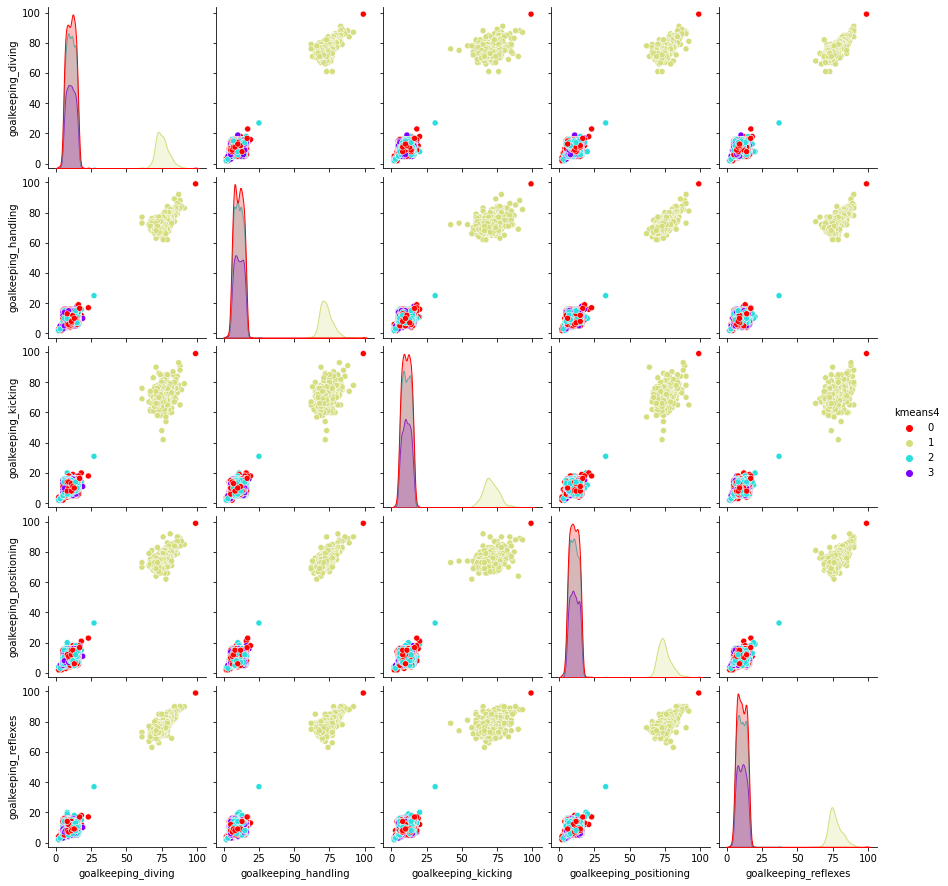

In [36]:
sns.pairplot(df_clust[skills_gk], hue = 'kmeans4', palette = 'rainbow_r');

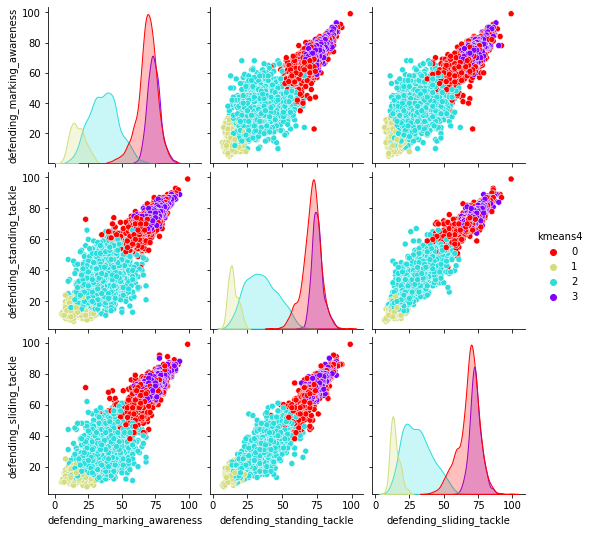

In [37]:
sns.pairplot(df_clust[skills_def], hue ='kmeans4', palette = 'rainbow_r');

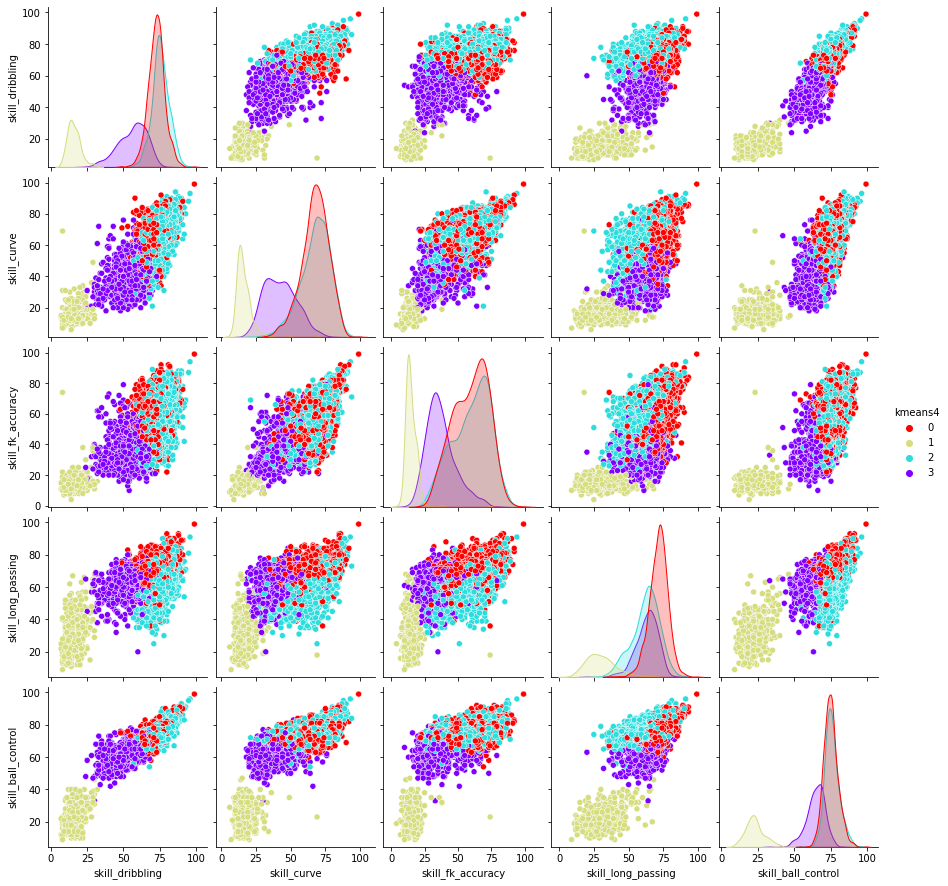

In [38]:
sns.pairplot(df_clust[skills_mid], hue ='kmeans4', palette = 'rainbow_r');

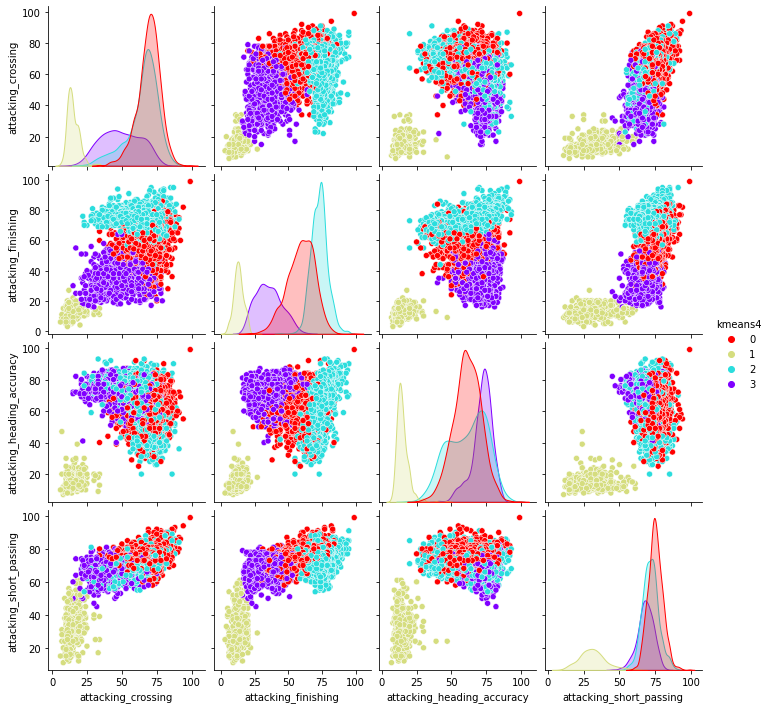

In [39]:
sns.pairplot(df_clust[skills_at], hue ='kmeans4', palette = 'rainbow_r');

# DBSCAN

In [40]:
dbscan = DBSCAN(eps = 16.4, min_samples = 2)
dbscan.fit(df2)

clusters_dbscan = dbscan.labels_
max(dbscan.labels_)

4

In [41]:
df_dbscan = df2.copy()
df_dbscan['dbscan'] = dbscan.labels_

print('DBSCAN encontro: ', max(dbscan.labels_)+1,
      'clusters, nosotros le proporcionamos el radio a tomar en cuenta y la cantidad de vecinos necesarios')

DBSCAN encontro:  5 clusters, nosotros le proporcionamos el radio a tomar en cuenta y la cantidad de vecinos necesarios


In [42]:
# Creamos un objeto con todas las skills
skills_ra = [ 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

# Skills de arquero:
skills_gk = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes','dbscan']

# Skills de defensor:
skills_def = [ 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle','dbscan']
# Skills de atacantes:
skills_at = ['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing', 'dbscan']

# Skills de mediocampo:
skills_mid = ['skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'dbscan']

# Skills de Movimiento y balance
skills_movement = ['movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'dbscan']

# Skills de Fuerza
skills_power = ['power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'dbscan']

# Skills Mentales
skills_mental = ['mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'dbscan']

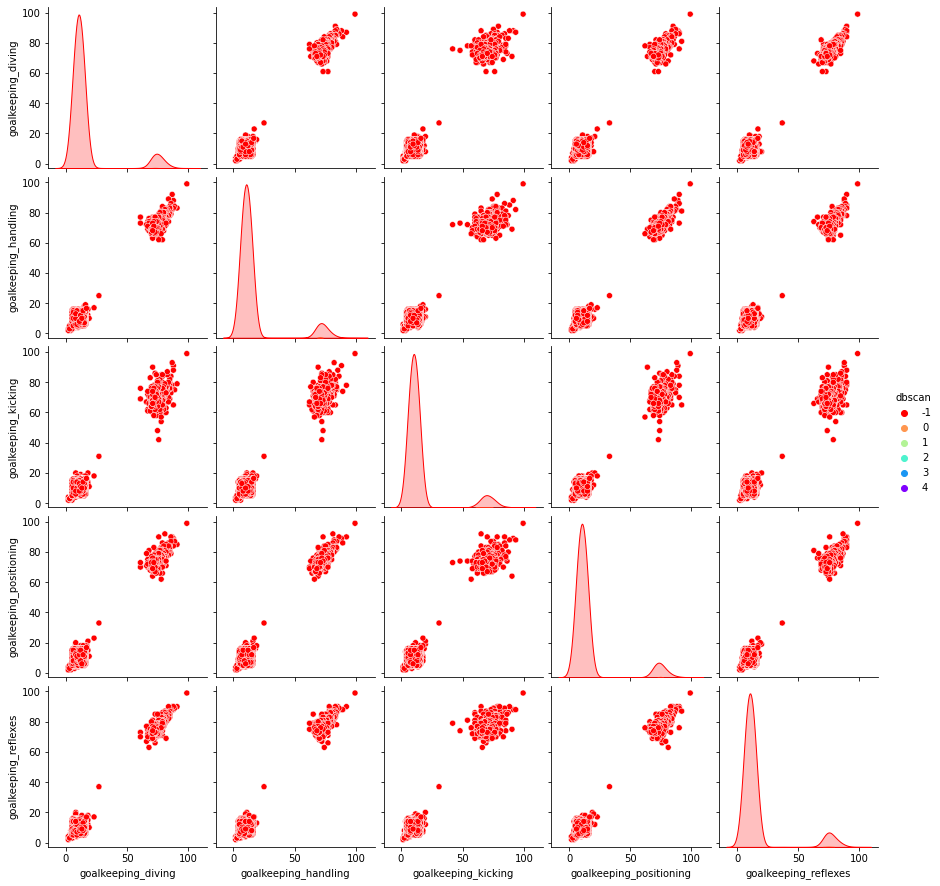

In [43]:
sns.pairplot(df_dbscan[skills_gk], hue = 'dbscan', palette = 'rainbow_r');

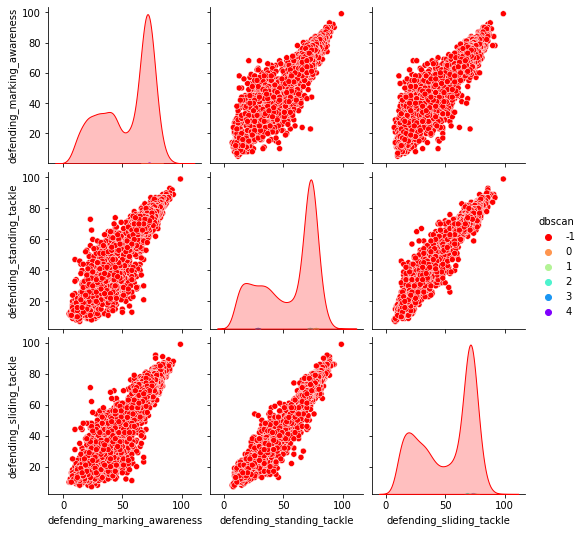

In [44]:
sns.pairplot(df_dbscan[skills_def], hue = 'dbscan', palette = 'rainbow_r');

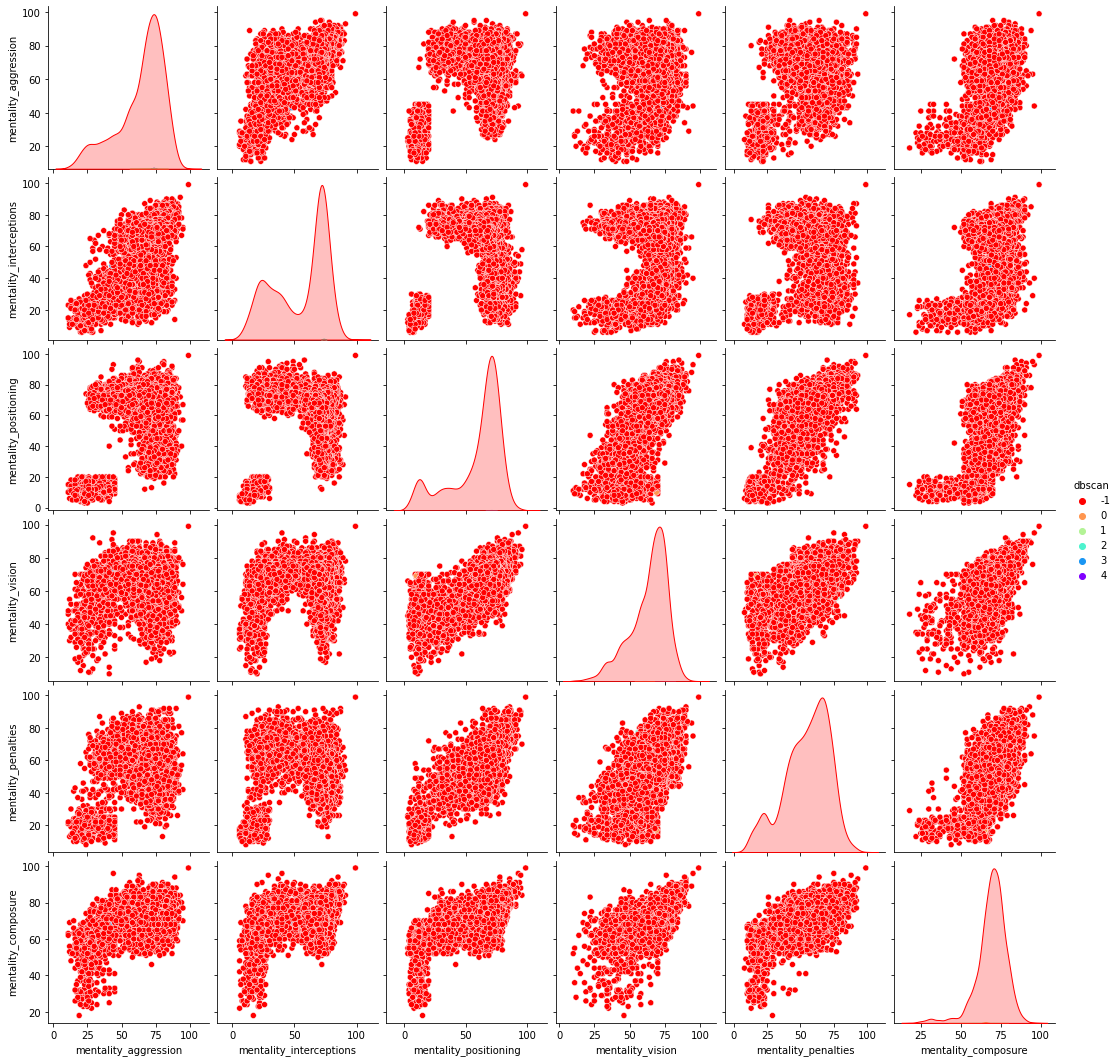

In [45]:
sns.pairplot(df_dbscan[skills_mental], hue = 'dbscan', palette = 'rainbow_r');